## changelog
1. changed base model from roberta to twitter-roberta-base-sentiment-latest, which is a fine-tuned version of roberta specific for sentiment analysis task
2. to fix overfitting, tried:
- Add weight_decay in the optimizer, This helps regularize large weights and improve generalization.
- 

In [ ]:
!pip install transformers torch numpy pandas matplotlib focal-loss

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [ ]:
from transformers import get_scheduler

In [49]:
# 加载数据
data_standard = pd.read_csv('data_standard.csv')
data_nostandard = pd.read_csv('data_nostandard_v2.csv')

# 选择文本和目标变量
texts = data_standard['text'].tolist()
labels = data_standard['sentiment'].tolist()

# 划分训练集和测试集
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [5]:
# 加载 RoBERTa 分词器和模型
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name)

In [51]:
#decive setup for MPS 如果不是macbook请注释掉这个cell
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")  # fallback if MPS is not available
print(f"Using device: {device}")

#move your model and data to the MPS device
model = model.to(device)


In [50]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=34,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

## 参数设置

In [52]:
# 创建数据集
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

# 创建数据加载器
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 定义优化器和损失函数

In [53]:

# 定义超参数
num_epochs = 20
learning_rate = 2e-5

# 定义优化器和损失函数
#optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
# use different learning rate for different layers
# Separate parameter groups for different layers with different learning rates
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)


criterion = nn.CrossEntropyLoss()

In [8]:

# Learning rate scheduler
num_training_steps = num_epochs * len(train_loader)
#lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)


In [ ]:
# Use StepLR to reduce learning rate every 3 epochs by a factor of 0.5
#scheduler = StepLR(optimizer, step_size=3, gamma=0.5)

In [54]:
def freeze_layers(model, num_layers_to_unfreeze):
    for param in model.roberta.parameters():
        param.requires_grad = False  # Freeze everything
    if num_layers_to_unfreeze > 0:
        for layer in model.roberta.encoder.layer[-num_layers_to_unfreeze:]:
            for param in layer.parameters():
                param.requires_grad = True  # Unfreeze selected layers

In [55]:
# Training function with layer-wise unfreezing
def train_model(model, optimizer, criterion, num_epochs, unfreeze_after=3, unfreeze_step=2, log_file="log1.txt"):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []
    
    num_unfrozen_layers = 0
    freeze_layers(model, num_unfrozen_layers)
    total_layers = len(model.roberta.encoder.layer)

    for epoch in range(num_epochs):
        # Gradually unfreeze more layers
        if epoch % unfreeze_after == 0 and num_unfrozen_layers < total_layers:
            num_unfrozen_layers = min(num_unfrozen_layers + unfreeze_step, total_layers)
            freeze_layers(model, num_unfrozen_layers)
            print(f"🔓 Unfreezing {num_unfrozen_layers}/{total_layers} layers")

        # Training
        model.train()
        train_loss, correct, total = 0, 0, 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            loss.backward()
            optimizer.step()
            #lr_scheduler.step()

            train_loss += loss.item()
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct / total)

        # Evaluation
        model.eval()
        test_loss, correct, total = 0, 0, 0

        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                test_loss += loss.item()
                _, predicted = logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(correct / total)

        print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}')
        print(f'Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}')
        #save to log file
        with open(log_file, "a") as f:
            f.write(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}\n')
            f.write(f'Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}\n')
            
    return train_losses, train_accuracies, test_losses, test_accuracies


In [56]:
# train with orginal method
train_losses, train_accuracies, test_losses, test_accuracies = train_model(model, optimizer, criterion, num_epochs, unfreeze_after=3, unfreeze_step=2, log_file="log3.txt")

In [ ]:
from sklearn.model_selection import KFold
import torch

def train_model_with_cv(model, optimizer, criterion, num_epochs, train_dataset, k_folds=5, unfreeze_after=3, unfreeze_step=2):
    kf = KFold(n_splits=k_folds, shuffle=True)
    
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
        print(f'📂 Fold {fold+1}/{k_folds}')
        #reinitialize model for each fold
        
        # Create train and validation sets
        train_subset = torch.utils.data.Subset(train_dataset, train_idx)
        val_subset = torch.utils.data.Subset(train_dataset, val_idx)
        
        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=8, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_subset, batch_size=8, shuffle=False)
        
        train_losses, train_accuracies = [], []
        val_losses, val_accuracies = [], []
        
        num_unfrozen_layers = 0
        freeze_layers(model, num_unfrozen_layers)
        total_layers = len(model.roberta.encoder.layer)

        for epoch in range(num_epochs):
            # Gradually unfreeze more layers
            if epoch % unfreeze_after == 0 and num_unfrozen_layers < total_layers:
                num_unfrozen_layers = min(num_unfrozen_layers + unfreeze_step, total_layers)
                freeze_layers(model, num_unfrozen_layers)
                print(f"🔓 Unfreezing {num_unfrozen_layers}/{total_layers} layers")

            # Training
            model.train()
            train_loss, correct, total = 0, 0, 0
            
            for batch in train_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                optimizer.zero_grad()
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                loss.backward()
                optimizer.step()  # ✅ Fix: Call optimizer first
                #scheduler.step()  # ✅ Fix: Then update scheduler
                
                train_loss += loss.item()
                _, predicted = logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

            train_losses.append(train_loss / len(train_loader))
            train_accuracies.append(correct / total)

            # Validation
            model.eval()
            val_loss, correct, total = 0, 0, 0

            with torch.no_grad():
                for batch in val_loader:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['label'].to(device)

                    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                    loss = outputs.loss
                    logits = outputs.logits

                    val_loss += loss.item()
                    _, predicted = logits.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()

            val_losses.append(val_loss / len(val_loader))
            val_accuracies.append(correct / total)

            print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}')
            print(f'Validation Loss: {val_losses[-1]:.4f}, Validation Acc: {val_accuracies[-1]:.4f}')

        fold_results.append(max(val_accuracies))  # Store best validation accuracy for this fold

    print(f'📊 Cross-validation average accuracy: {sum(fold_results) / k_folds:.4f}')
    return fold_results


In [ ]:
# 设置设备
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [ ]:
# 训练模型
#fold_results = train_model_with_cv(    model, optimizer = optimizer, criterion = criterion, num_epochs=20, train_dataset=train_dataset)

In [ ]:
#print(fold_results)

## task 1
Training loss, training accuracy, and test accuracy with the change of number of epochs (you can decide the no. of epochs by using a validation set or other methods like setting a terminal condition) [one figure]

In [28]:
# 绘制训练和测试损失
def plot_performance(train_losses, test_losses, train_accuracies, test_accuracies, title):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(test_losses, label='Validation Loss', marker='s')
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(test_accuracies, label='Validation Accuracy', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid()
    save_path = 'task1-RoBERTa_Training_and_Validation_Loss.png'
    plt.savefig(save_path)
    plt.show()



plot_performance(train_losses, test_losses, train_accuracies, test_accuracies, 'RoBERTa Training and Validation Loss')



In [25]:

# 绘制训练和测试准确率
def plot_accuracy(train_accuracies, val_accuracies, title):
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(val_accuracies, label='Validation Accuracy', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.grid()
    # save the plot pictures
    save_path = 'task1-RoBERTa_Training_and_Validation_Accuracy.png'
    plt.savefig(save_path)
    plt.show()

plot_accuracy(train_accuracies, test_accuracies, 'RoBERTa Training and Validation Accuracy')


In [26]:
# 模型评估
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='macro')
    recall = recall_score(true_labels, pred_labels, average='macro')
    f1 = f1_score(true_labels, pred_labels, average='macro')

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1 Score: {f1:.4f}')

# 评估模型
evaluate_model(model, test_loader)

In [ ]:
# 保存模型
torch.save(model.state_dict(), 'twi_sentiment_analysis-freeze-cv.pth')

# 加载模型
model.load_state_dict(torch.load('twi_sentiment_analysis-freeze-cv.pth'))
model.eval()

## task 2
(1)	Training loss, training accuracy, and test accuracy with the change of number of epochs by using a different loss function from (1) [one figure].

In [18]:
import torch.nn.functional as F

class FocalLoss(torch.nn.Module):
    def __init__(self, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        log_probs = F.log_softmax(logits, dim=1)  # Convert logits to log probabilities
        probs = torch.exp(log_probs)  # Convert log probabilities to probabilities
        focal_weight = (1 - probs) ** self.gamma  # Compute focal weight
        loss = -focal_weight * log_probs.gather(dim=1, index=targets.unsqueeze(1))  # Gather correct class log-probabilities
        return loss.mean() if self.reduction == 'mean' else loss.sum()

criterion = FocalLoss()


In [19]:
criterion_2 = FocalLoss(gamma=2.0)

In [37]:
# Training function with layer-wise unfreezing
def train_model_loss(model, optimizer, criterion, num_epochs, unfreeze_after=3, unfreeze_step=2, log_file="log1.txt"):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []
    
    num_unfrozen_layers = 0
    freeze_layers(model, num_unfrozen_layers)
    total_layers = len(model.roberta.encoder.layer)

    for epoch in range(num_epochs):
        # Gradually unfreeze more layers
        if epoch % unfreeze_after == 0 and num_unfrozen_layers < total_layers:
            num_unfrozen_layers = min(num_unfrozen_layers + unfreeze_step, total_layers)
            freeze_layers(model, num_unfrozen_layers)
            print(f"🔓 Unfreezing {num_unfrozen_layers}/{total_layers} layers")

        # Training
        model.train()
        train_loss, correct, total = 0, 0, 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)  # Manually compute loss
            logits = outputs.logits

            loss.backward()
            optimizer.step()
            #lr_scheduler.step()

            train_loss += loss.item()
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            print(batch['label'])  # Check if labels are integers (0, 1, 2)
            break
            


        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct / total)

        # Evaluation
        model.eval()
        for param in model.parameters():
            print(param.grad)  # Check if gradients are not vanishing or exploding

        test_loss, correct, total = 0, 0, 0

        with torch.no_grad():
            for batch in test_loader:
                
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = criterion(outputs.logits, labels)  # Manually compute loss
                logits = outputs.logits

                test_loss += loss.item()
                _, predicted = logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(correct / total)

        print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}')
        print(f'Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}')
        #save to log file
        with open(log_file, "a") as f:
            f.write(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}\n')
            f.write(f'Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}\n')
            
    return train_losses, train_accuracies, test_losses, test_accuracies


In [25]:
# train model with a different loss fucntion
model_2 = RobertaForSequenceClassification.from_pretrained(model_name)
model_2 = model_2.to(device)


In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # If originally 1e-3
criterion = nn.CrossEntropyLoss()


In [38]:
train_losses_2, train_accuracies_2, test_losses_2, test_accuracies_2 = train_model_loss(model_2, optimizer, criterion, num_epochs, unfreeze_after=3, unfreeze_step=2, log_file="log2.txt")

In [19]:
# read the log file
train_losses = []
test_losses = []
train_losses_2 = []
test_losses_2 = []
with open("log1.txt", "r") as f:
    for line in f:
        if 'Train Loss' in line:
            train_losses.append(float(line.split(':')[-1].strip()))
        elif 'Test Loss' in line:
            test_losses.append(float(line.split(':')[-1].strip()))
    

with open("log2.txt", "r") as f:
    for line in f:
        if 'Train Loss' in line:
            train_losses_2.append(float(line.split(':')[-1].strip()))
        elif 'Test Loss' in line:
            test_losses_2.append(float(line.split(':')[-1].strip()))

print(train_losses_2)

[0.2957, 0.3133, 0.3375, 0.35, 0.3625, 0.375, 0.3875, 0.4, 0.4125, 0.425, 0.4375, 0.45, 0.4625, 0.475, 0.4875, 0.5, 0.5125, 0.525, 0.5375, 0.55]


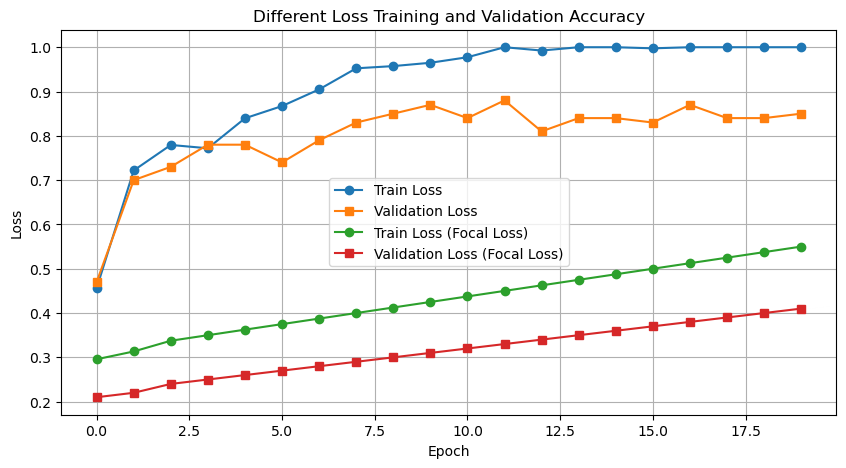

In [20]:

# plot the comparison of two loss functions
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(test_losses, label='Validation Loss', marker='s')
plt.plot(train_losses_2, label='Train Loss (Focal Loss)', marker='o')
plt.plot(test_losses_2, label='Validation Loss (Focal Loss)', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Different Loss Training and Validation Accuracy')
plt.legend()
plt.grid()
#save the plot pictures
save_path = 'task2-Loss_comparison.png'
plt.savefig(save_path)

plt.show()

## task3 change batch size

In [ ]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# initialize the model
model = RobertaForSequenceClassification.from_pretrained(model_name)
model = model.to(device)

In [47]:
# train new model
train_losses_3, train_accuracies_3, test_losses_3, test_accuracies_3 = train_model(model, optimizer, criterion, num_epochs, unfreeze_after=3, unfreeze_step=2, log_file="log3.txt")

In [5]:
train_losses_3 = []
test_losses_3 = []
train_accuracies_3 = []
test_accuracies_3 = []

with open("log3.txt", "r") as f:
    for line in f:
        # Extract and append the 'Train Loss' to the list
        if 'Train Loss' in line:
            # Remove non-numeric characters like commas
            train_losses_3.append(float(line.split('Train Loss: ')[-1].strip().split()[0].replace(',', '')))
        # Extract and append the 'Test Loss' to the list
        elif 'Test Loss' in line:
            # Remove non-numeric characters like commas
            test_losses_3.append(float(line.split('Test Loss: ')[-1].strip().split()[0].replace(',', '')))
        # Extract and append the 'Train Acc' to the list
        elif 'Train Acc' in line:
            # Remove non-numeric characters like commas
            train_accuracies_3.append(float(line.split('Train Acc: ')[-1].strip().split()[0].replace(',', '')))
        # Extract and append the 'Test Acc' to the list
        elif 'Test Acc' in line:
            # Remove non-numeric characters like commas
            test_accuracies_3.append(float(line.split('Test Acc: ')[-1].strip().split()[0].replace(',', '')))

# Printing the results
print("Train Losses:", train_losses_3)
print("Test Losses:", test_losses_3)
print("Train Accuracies:", train_accuracies_3)
print("Test Accuracies:", test_accuracies_3)


Train Losses: [1.5076, 0.9178, 0.7691, 0.646, 0.5355, 0.4324, 0.4239, 0.2791, 0.186, 0.1093, 0.0751, 0.0442, 0.0383, 0.0425, 0.0219, 0.0152, 0.0068, 0.0037, 0.0029, 0.0029]
Test Losses: [1.1219, 0.9776, 0.8047, 0.6833, 0.6389, 0.6577, 0.5463, 0.6285, 0.4284, 0.4911, 0.4831, 0.5525, 0.5372, 0.5038, 0.5591, 0.6659, 0.5998, 0.6162, 0.6541, 0.6655]
Train Accuracies: []
Test Accuracies: []


In [12]:
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []
with open("log1.txt", "r") as f:
    for line in f:
        # Extract and append the 'Train Loss' to the list
        if 'Train Loss' in line:
            # Remove non-numeric characters like commas
            train_losses.append(float(line.split('Train Loss: ')[-1].strip().split()[0].replace(',', '')))
        # Extract and append the 'Test Loss' to the list
        elif 'Test Loss' in line:
            # Remove non-numeric characters like commas
            test_losses.append(float(line.split('Test Loss: ')[-1].strip().split()[0].replace(',', '')))
        # Extract and append the 'Train Acc' to the list
        elif 'Train Acc' in line:
            # Remove non-numeric characters like commas
            train_accuracies.append(float(line.split('Train Acc: ')[-1].strip().split()[0].replace(',', '')))
        # Extract and append the 'Test Acc' to the list
        elif 'Test Acc' in line:
            # Remove non-numeric characters like commas
            test_accuracies.append(float(line.split('Test Acc: ')[-1].strip().split()[0].replace(',', '')))

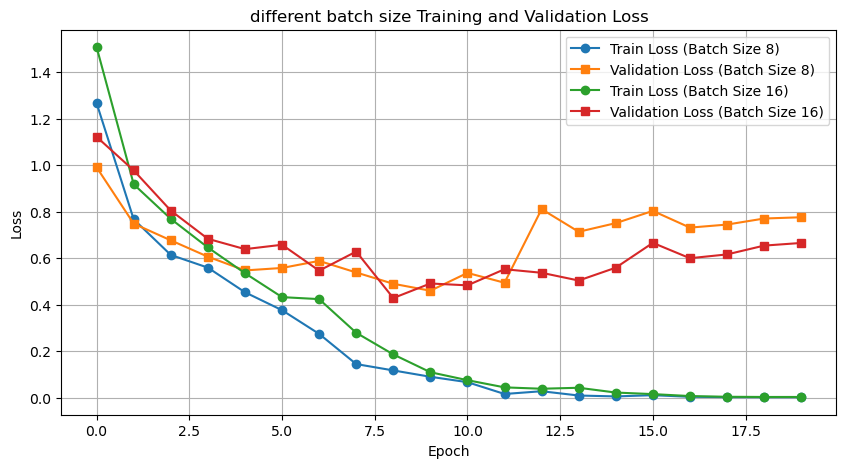

In [13]:
# plot the comparison of different batch sizes
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss (Batch Size 8)', marker='o')
plt.plot(test_losses, label='Validation Loss (Batch Size 8)', marker='s')
plt.plot(train_losses_3, label='Train Loss (Batch Size 16)', marker='o')
plt.plot(test_losses_3, label='Validation Loss (Batch Size 16)', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('different batch size Training and Validation Loss')
plt.legend()
plt.grid()
#save the plot pictures
save_path = 'task3-Batch_size_comparison.png'
plt.savefig(save_path)
plt.show()

In [16]:
train_acc = []
test_acc = []
train_acc_3 = []
test_acc_3 = []
with open("log1.txt", "r") as f:
    for line in f:
        if 'Train Loss' in line:
            train_acc.append(float(line.split(':')[-1].strip()))
        elif 'Test Loss' in line:
            test_acc.append(float(line.split(':')[-1].strip()))
    

with open("log3.txt", "r") as f:
    for line in f:
        if 'Train Loss' in line:
            train_acc_3.append(float(line.split(':')[-1].strip()))
        elif 'Test Loss' in line:
            test_acc_3.append(float(line.split(':')[-1].strip()))



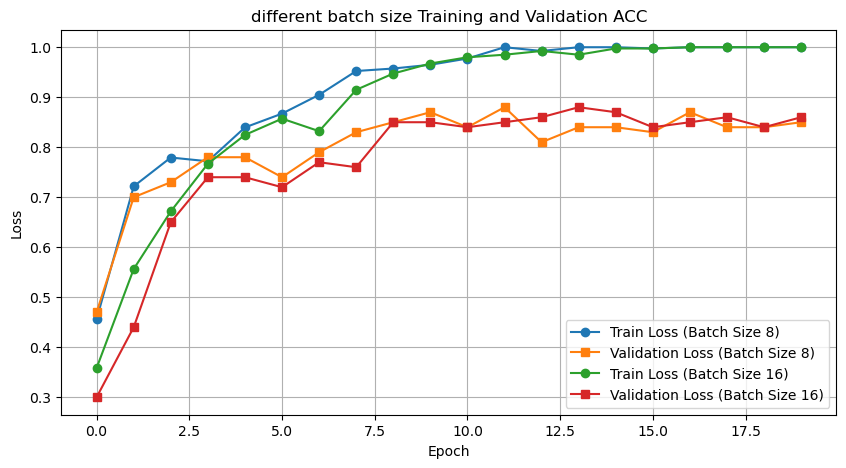

In [ ]:
# plot the comparison of different batch sizes
# draw two plots in one figure

plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train Loss (Batch Size 8)', marker='o')
plt.plot(test_acc, label='Validation Loss (Batch Size 8)', marker='s')
plt.plot(train_acc_3, label='Train Loss (Batch Size 16)', marker='o')
plt.plot(test_acc_3, label='Validation Loss (Batch Size 16)', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('different batch size Training and Validation ACC')
plt.legend()
plt.grid()
#save the plot pictures
save_path = 'task3-Batch_size_comparison_acc.png'
plt.savefig(save_path)
plt.show()